
# Assignment 03

In [1]:
#Set Path to the datasets
from google.colab import drive
drive.mount('/content/drive')
train_images = 'drive/My Drive/dataset/images_prepped_train'
test_images = 'drive/My Drive/dataset/images_prepped_test'
train_y = 'drive/My Drive/dataset/annotations_prepped_train'
test_y = 'drive/My Drive/dataset/annotations_prepped_test'

#Fix width and height to 224x224
width = 224
Height = 224
#Number of class labels
n_class=12

Mounted at /content/drive


### Installing and Importing Dependencies and Utilities

In [2]:
!pip install -U segmentation-models
!pip install -U --pre segmentation-models
!pip install te
!pip install keras.utils

In [3]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [4]:
import time
start_time = time.time()


#Training Data
tr_images = []

for dir_path in glob.glob(train_images):
    for image_path in glob.glob(os.path.join(dir_path, "*.png")):
        image = cv2.imread(image_path, 1)       
        image = cv2.resize(image, (Height, width))
        image = image / 255.0
        image = image.astype(np.float32)
        tr_images.append(image)
       
#Training Images as Numpy Array       
tr_images = np.array(tr_images)

#Mask Labels
tr_masks = [] 
for dir_path in glob.glob(train_y):
    for m_path in glob.glob(os.path.join(dir_path, "*.png")):
        msk = cv2.imread(m_path, 0)       
        msk = cv2.resize(msk, (Height, width), interpolation = cv2.INTER_NEAREST)
        msk = msk.astype(np.int32)  
        tr_masks.append(msk)
        
#Masks as numpy array          
tr_masks = np.array(tr_masks)


#Testing Data
ts_images = []

for dir_path in glob.glob(test_images):
    for image_path in glob.glob(os.path.join(dir_path, "*.png")):
        image = cv2.imread(image_path, 1)       
        image = cv2.resize(image, (Height, width))
        image = image / 255.0
        image = image.astype(np.float32)
        ts_images.append(image)
       
#Testing Data as Numpy array        
ts_images = np.array(ts_images)

#MAsks of Test
ts_masks = [] 
for dir_path in glob.glob(test_y):
    for msk_path in glob.glob(os.path.join(dir_path, "*.png")):
        msk = cv2.imread(msk_path, 0)       
        msk = cv2.resize(msk, (Height, width), interpolation = cv2.INTER_NEAREST)
        msk = msk.astype(np.int32)
        ts_masks.append(msk)
        
#Test Mask as numpy array          
ts_masks = np.array(ts_masks)
print("--%s--"%(time.time()-start_time))

--196.5154514312744--


In [5]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
x, y, z = tr_masks.shape
x1, y1, z1 = ts_masks.shape
tr_msk_reshaped = tr_masks.reshape(-1,1)
ts_msk_reshaped = ts_masks.reshape(-1,1)
tr_msk_reshaped_encoded = labelencoder.fit_transform(tr_msk_reshaped)
ts_msk_reshaped_encoded = labelencoder.fit_transform(ts_msk_reshaped)
tr_msk_encoded_original_shape = tr_msk_reshaped_encoded.reshape(x, y, z)
ts_msk_encoded_original_shape = ts_msk_reshaped_encoded.reshape(x1, y1, z1)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
#Train and test Masks
tr_masks_input = np.expand_dims(tr_msk_encoded_original_shape, axis=3)
ts_masks_input = np.expand_dims(ts_msk_encoded_original_shape, axis=3)

In [7]:
#Spliting into training and validation sets 
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(tr_images, tr_masks_input, test_size=0.2, random_state=42)

In [8]:

tr_msks_cat = to_categorical(y_train, num_classes=n_class)
y_tr_cat = tr_msks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2],n_class))

val_msk_cat = to_categorical(y_val, num_classes=n_class)
y_val_cat = val_msk_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2],n_class))

ts_masks_cat = to_categorical(ts_masks_input, num_classes=n_class)
y_test_cat = ts_masks_cat.reshape((ts_masks_input.shape[0], ts_masks_input.shape[1], ts_masks_input.shape[2],n_class))

In [9]:
activation='softmax'

import tensorflow as tf

alpha = 0.0001

optim = tf.keras.optimizers.Adam(alpha)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.0909090909,0.0909090909,0.0909090909,0.0909090909,0.0909090909,0.0909090909,0.0909090909,0.0909090909,0.0909090909,0.0909090909,0.0909090909])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [10]:

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [11]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [12]:
#Model1 RESNET50_UNET
BACKBONE_1 = 'resnet50'

preprocess_input1 = sm.get_preprocessing(BACKBONE_1)

# Preprocessing
X_train1 = preprocess_input1(x_train)
X_test1 = preprocess_input1(ts_images)
X_val1 = preprocess_input1(x_val)

# Define architecture
model1 = sm.Unet(BACKBONE_1, encoder_weights='imagenet', classes=n_class, activation=activation)

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

94601216/94592056 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [13]:
#Model 2 VGG16_UNET
BACKBONE_2 = 'vgg16'

preprocess_input2 = sm.get_preprocessing(BACKBONE_2)

# Preprocessing
X_train2 = preprocess_input2(x_train)
X_test2 = preprocess_input2(ts_images)
X_val2 = preprocess_input2(x_val)

# Define Architechture
model2 = sm.Unet(BACKBONE_2, encoder_weights='imagenet', classes = n_class, activation=activation)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model2.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                           

In [14]:
#Resnet_UNET
his1=model1.fit(X_train1, 
          y_tr_cat,
          batch_size=8, 
          epochs=30,
          verbose=1,
          validation_data=(X_val1,y_val_cat))

Epoch 1/30
37/37 [==============================] - 43s 615ms/step - loss: 1.4539 - iou_score: 0.0909 - f1-score: 0.1185 - val_loss: 374.2442 - val_iou_score: 0.0284 - val_f1-score: 0.0414
Epoch 2/30
37/37 [==============================] - 16s 437ms/step - loss: 1.1572 - iou_score: 0.1291 - f1-score: 0.1634 - val_loss: 5.4567 - val_iou_score: 0.0246 - val_f1-score: 0.0355
Epoch 3/30
37/37 [==============================] - 16s 440ms/step - loss: 1.1139 - iou_score: 0.1294 - f1-score: 0.1636 - val_loss: 4.3871 - val_iou_score: 0.0302 - val_f1-score: 0.0445
Epoch 4/30
37/37 [==============================] - 16s 441ms/step - loss: 1.0808 - iou_score: 0.1366 - f1-score: 0.1720 - val_loss: 1.3095 - val_iou_score: 0.1335 - val_f1-score: 0.1692
Epoch 5/30
37/37 [==============================] - 16s 440ms/step - loss: 1.0736 - iou_score: 0.1367 - f1-score: 0.1720 - val_loss: 1.2523 - val_iou_score: 0.1386 - val_f1-score: 0.1749
Epoch 6/30
37/37 [==============================] - 16s 441ms/s

In [15]:
#VGG_UNET
his2=model2.fit(X_train2, 
          y_tr_cat,
          batch_size=8, 
          epochs=30,
          verbose=1,
          validation_data=(X_val2,y_val_cat))

Epoch 1/30
37/37 [==============================] - 33s 690ms/step - loss: 1.9619 - iou_score: 0.0155 - f1-score: 0.0265 - val_loss: 17.0505 - val_iou_score: 0.0363 - val_f1-score: 0.0510
Epoch 2/30
37/37 [==============================] - 19s 512ms/step - loss: 1.4307 - iou_score: 0.0826 - f1-score: 0.1074 - val_loss: 1.9253 - val_iou_score: 0.0283 - val_f1-score: 0.0440
Epoch 3/30
37/37 [==============================] - 19s 512ms/step - loss: 1.2098 - iou_score: 0.1150 - f1-score: 0.1467 - val_loss: 5.7784 - val_iou_score: 0.0287 - val_f1-score: 0.0438
Epoch 4/30
37/37 [==============================] - 19s 512ms/step - loss: 1.1599 - iou_score: 0.1202 - f1-score: 0.1535 - val_loss: 9.7100 - val_iou_score: 0.0274 - val_f1-score: 0.0415
Epoch 5/30
37/37 [==============================] - 19s 512ms/step - loss: 1.1308 - iou_score: 0.1299 - f1-score: 0.1657 - val_loss: 2.3748 - val_iou_score: 0.0223 - val_f1-score: 0.0339
Epoch 6/30
37/37 [==============================] - 19s 511ms/st

In [16]:
#Resnet_UNET
eval_one = model1.evaluate(X_test1, y_test_cat , verbose=1)


4/4 [==============================] - 6s 306ms/step - loss: 1.8222 - iou_score: 0.1465 - f1-score: 0.1996


In [17]:
#VGG_UNET
eval_two= model2.evaluate(X_test2, y_test_cat , verbose=1)


4/4 [==============================] - 12s 334ms/step - loss: 1.2925 - iou_score: 0.1156 - f1-score: 0.1507


In [18]:
start_time = time.time()
predict_1 = model1.predict(X_test1) #Restnet_UNET Prediction
print("--%s Resnet_unet"%(time.time()-start_time))
start_time = time.time()
predict_2 = model2.predict(X_test2) #VGG_UNET Prediction
print("--%s VGG_UNET"%(time.time()-start_time))

--2.4234728813171387 Resnet_unet
--1.9446985721588135 VGG_UNET


In [20]:
#Result of Restnet_UNET
result1 = np.zeros((predict_1.shape[0],predict_1.shape[1],predict_1.shape[2]),dtype='int')
for n in range(predict_1.shape[0]):
  for x in range(predict_1.shape[1]):
    for y in range(predict_1.shape[2]):
      result1[n,x,y]=np.argmax(predict_1[n,x,y],axis=0)

#Result of VGG_UNET
result2 = np.zeros((predict_2.shape[0],predict_2.shape[1],predict_2.shape[2]),dtype='int')
for n in range(predict_2.shape[0]):
  for x in range(predict_2.shape[1]):
    for y in range(predict_2.shape[2]):
      result2[n,x,y]=np.argmax(predict_2[n,x,y],axis=0)

In [22]:
# Preparing image for prediction
Testing_images = []

for dir_path in glob.glob(test_images):
    for image_path in glob.glob(os.path.join(dir_path, "*.png")):
        image = cv2.imread(image_path, 1)       
        image = cv2.resize(image, (Height, width))
        Testing_images.append(image)
Testing_masks = [] 
for dir_path in glob.glob(test_y):
    for msk_path in glob.glob(os.path.join(dir_path, "*.png")):
        msk = cv2.imread(msk_path, 0)       
        msk = cv2.resize(msk, (Height, width), interpolation = cv2.INTER_NEAREST)
        Testing_masks.append(msk)


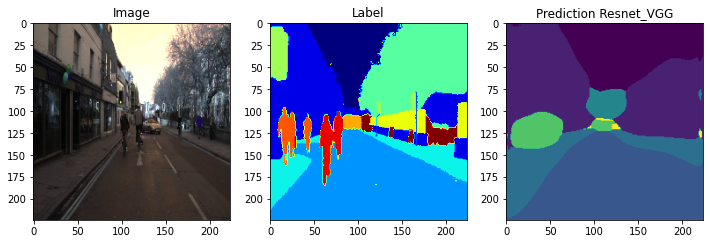

In [27]:
# Resnet_UNET Prediction
image_test = Testing_images[4]
actual = Testing_masks[4]
pred = result1[4]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(image_test)
plt.subplot(232)
plt.title('Label')
plt.imshow(actual,cmap='jet')
plt.subplot(233)
plt.title('Prediction Resnet_VGG')
plt.imshow(pred)
plt.show()

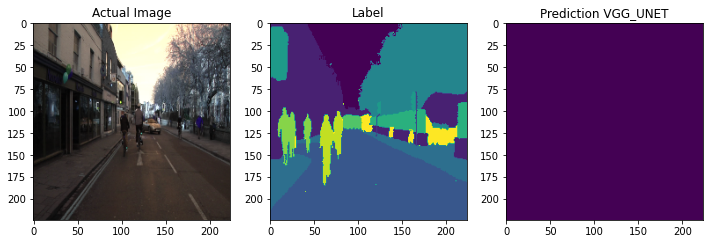

In [30]:
#VGG_UNET Prediction
test_img = Testing_images[4]
ground_truth = Testing_masks[4]
predicted_img = resul2[4]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Actual Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction VGG_UNET')
plt.imshow(predicted_img)
plt.show()

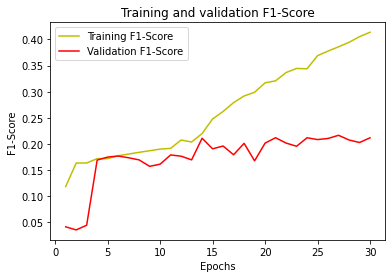

In [33]:
# Resnet_UNET
f1score = his1.history['f1-score']
val_f1score = his1.history['val_f1-score']
epochs = range(1, len(f1score) + 1)
plt.plot(epochs, f1score, 'y', label='Training F1-Score')
plt.plot(epochs, val_f1score, 'r', label='Validation F1-Score')
plt.title('Training and validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()


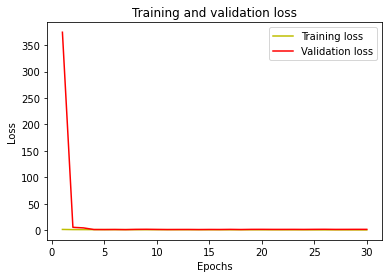

In [34]:
loss = his1.history['loss']
val_loss = his1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


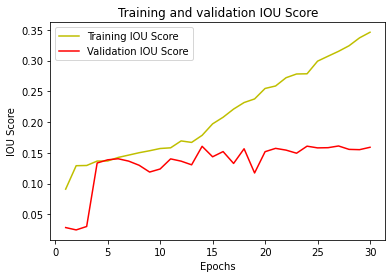

In [35]:

score = his1.history['iou_score']
val_score = his1.history['val_iou_score']
epochs = range(1, len(score) + 1)
plt.plot(epochs, score, 'y', label='Training IOU Score')
plt.plot(epochs, val_score, 'r', label='Validation IOU Score')
plt.title('Training and validation IOU Score')
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.legend()
plt.show()


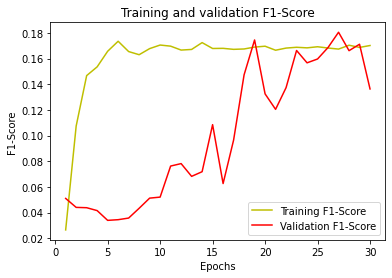

In [36]:
f1score = his2.history['f1-score']
val_f1score = his2.history['val_f1-score']
epochs = range(1, len(f1score) + 1)
plt.plot(epochs, f1score, 'y', label='Training F1-Score')
plt.plot(epochs, val_f1score, 'r', label='Validation F1-Score')
plt.title('Training and validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

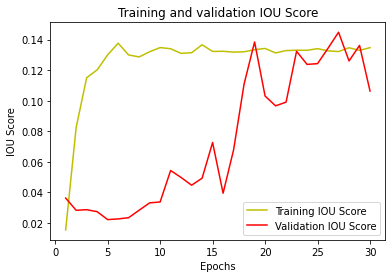

In [37]:
score = his2.history['iou_score']
val_score = his2.history['val_iou_score']
epochs = range(1, len(score) + 1)
plt.plot(epochs, score, 'y', label='Training IOU Score')
plt.plot(epochs, val_score, 'r', label='Validation IOU Score')
plt.title('Training and validation IOU Score')
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.legend()
plt.show()

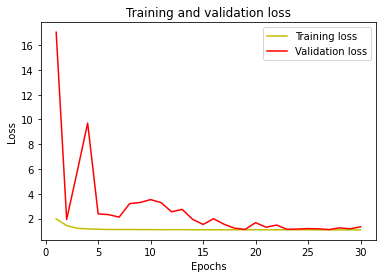

In [38]:
loss = his2.history['loss']
val_loss = his2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()